# Introduction to Machine Learning

<img src="logo.jpg" style="float: left; width: 15%" />

[CSE204-2018](https://moodle.polytechnique.fr/course/view.php?id=6784) Lab session #03

Jérémie DECOCK

<a href="https://colab.research.google.com/github/jeremiedecock/polytechnique-cse204-2018/blob/master/lab_session_03.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/jeremiedecock/polytechnique-cse204-2018/master?filepath=lab_session_03.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open and Execute in Binder"></a>

## Objectives

- Introduction to parametric models
- Implement a linear regressor
- Approximate the optimal parameters using a gradient descent algorithm
- Linear regression with Scikit Learn
- Implement a polynomial regressor

## Imports and tool functions

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

In [2]:
def gen_1d_linear_regression_samples(n_samples = 20):

    x = np.random.uniform(low=-10., high=10., size=n_samples)
    y = 2. * x + 3. + np.random.normal(scale=2., size=x.shape)

    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])

    df = sklearn.utils.shuffle(df).reset_index(drop=True)
    
    return df

In [3]:
def gen_1d_polynomial_regression_samples(n_samples = 15):

    x = np.random.uniform(low=0., high=10., size=n_samples)
    #x = np.random.uniform(low=0., high=1., size=n_samples)

    y = 3. - 2. * x + x ** 2 - x ** 3 + np.random.normal(scale=10., size=x.shape)
    #y = np.cos(1.5 * np.pi * x) + np.random.normal(scale=0.1, size=x.shape)

    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])

    df = sklearn.utils.shuffle(df).reset_index(drop=True)

    return df

In [4]:
def plot_1d_regression_samples(dataframe, model=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    df = dataframe  # make an alias
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1
    
    if model is not None:
        
        # Compute the model's prediction
        
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_pred)
        
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    
    df.plot.scatter(x='x', y='y', ax=ax)
    
    delta_y = df.y.max() - df.y.min()
    
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))

In [5]:
def plot_ex2(X, y, theta_0=None, theta_1=None):
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x="x", y="y")

    if theta_0 is not None and theta_1 is not None:
        x = np.array([1, 9])
        y = theta_0 + theta_1 * x

        ax.plot(x, y, "--r")

In [6]:
def plot_ex4(X, y, theta_1=None, theta_2=None):
    df = pd.DataFrame(np.array([X, y]).T, columns=['x', 'y'])

    ax = df.plot.scatter(x="x", y="y")

    if theta_1 is not None and theta_2 is not None:
        x = np.linspace(0, 6, 50)
        y = theta_1 * x + theta_2 * x**2

        ax.plot(x, y, "--r")

In [7]:
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

def plot_contour_2d_solution_space(func,
                                   fig=None,
                                   ax=None,
                                   show=True,
                                   xmin=-np.ones(2),
                                   xmax=np.ones(2),
                                   xstar=None,
                                   xvisited=None,
                                   title=""):
    """Plot points visited during the execution of an optimization algorithm."""
    if (fig is None) or (ax is None):                # TODO
        fig, ax = plt.subplots(figsize=(12, 8))

    if xvisited is not None:
        xmin = np.amin(np.hstack([xmin.reshape([-1, 1]), xvisited]), axis=1)
        xmax = np.amax(np.hstack([xmax.reshape([-1, 1]), xvisited]), axis=1)

    x1_space = np.linspace(xmin[0], xmax[0], 200)
    x2_space = np.linspace(xmin[1], xmax[1], 200)

    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)

    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)

    ############################

    if xstar is not None:
        min_value = func(xstar)
    else:
        min_value = zz.min()
        
    max_value = zz.max()

    levels = np.logspace(0.1, 3., 5)          # TODO

    im = ax.pcolormesh(x1_mesh, x2_mesh, zz,
                       vmin=0.1,              # TODO
                       vmax=max_value,
                       norm=colors.LogNorm(), # TODO
                       shading='gouraud',
                       cmap='gnuplot2') # 'jet' # 'gnuplot2'

    plt.colorbar(im, ax=ax)

    cs = plt.contour(x1_mesh, x2_mesh, zz, levels,
                     linewidths=(2, 2, 2, 2, 3),
                     linestyles=('dotted', '-.', 'dashed', 'solid', 'solid'),
                     alpha=0.5,
                     colors='white')
    ax.clabel(cs, inline=False, fontsize=12)

    ############################

    if xvisited is not None:
        ax.plot(xvisited[0],
                xvisited[1],
                '-og',
                alpha=0.5,
                label="$visited$")

    ############################

    if xstar is not None:
        sc = ax.scatter(xstar[0],
                   xstar[1],
                   c='red',
                   label="$x^*$")
        sc.set_zorder(10)        # put this point above every thing else

    ############################

    ax.set_title(title)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    ax.legend(fontsize=12)

    if show:
        plt.show()

    return fig, ax


def plot_2d_solution_space(func,
                           fig=None,
                           ax=None,
                           show=True,
                           xmin=-np.ones(2),
                           xmax=np.ones(2),
                           xstar=None,
                           xvisited=None,
                           angle_view=None,
                           title=""):
    """Plot points visited during the execution of an optimization algorithm."""
    if fig is None or ax is None:                # TODO
        fig = plt.figure(figsize=(12, 8))
        ax = axes3d.Axes3D(fig)

    if angle_view is not None:
        ax.view_init(angle_view[0], angle_view[1])

    x1_space = np.linspace(xmin[0], xmax[0], 100)
    x2_space = np.linspace(xmin[1], xmax[1], 100)

    x1_mesh, x2_mesh = np.meshgrid(x1_space, x2_space)

    zz = func(np.array([x1_mesh.ravel(), x2_mesh.ravel()])).reshape(x1_mesh.shape)   # TODO

    ############################

    surf = ax.plot_surface(x1_mesh,
                           x2_mesh,
                           zz,
                           cmap='gnuplot2', # 'jet' # 'gnuplot2'
                           norm=colors.LogNorm(),   # TODO
                           rstride=1,
                           cstride=1,
                           #color='b',
                           shade=False)

    ax.set_zlabel(r"$f(x_1, x_2)$")

    fig.colorbar(surf, shrink=0.5, aspect=5)

    ############################

    if xstar is not None:
        ax.scatter(xstar[0],
                   xstar[1],
                   func(xstar),
                   #s=50,          # TODO
                   c='red',
                   alpha=1,
                   label="$x^*$")

    ax.set_title(title)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    ax.legend(fontsize=12)

    if show:
        plt.show()

    return fig, ax

## Introduction

In the previous lab session, you have used a **non-parametric models** (k Nearest Neighbors) to solve classification and regression problems.
Today you will learn to solve regression problems using **parametric models** (the application of parametric models to classification problems will be the subject of the next session): you will use a parametric function $f_{\boldsymbol{\theta}}: \boldsymbol{x} \mapsto y$ to infer the link existing between input vectors $\boldsymbol{x} \in \mathbb{R}^p$ and output values $y \in \mathbb{R}$ in a *learning set* $\mathcal{D} = \{(y^{(i)}, \boldsymbol{x^{(i)}})\}_{1 \leq i \leq n}$ of $n$ examples.

The *hypothesis space* $\mathcal{H}$ of $f_{\boldsymbol{\theta}}$ is a priori chosen so that the model fits reasonably well the data in $\mathcal{D}$. For instance, $\mathcal{H}$ can be the space of affine functions if data seems to be distributed along a line in $\mathcal{D}$. The space of polynomial function of degree $d$ may be a good choice otherwise.

The parameter $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ is then searched to obtain the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$ (optimization problem).

For instance, assuming you have chosen the space of affine functions to make a model that describes data you have in $\mathcal{D}$. Your model is then $y = \theta_0 + \theta_1 x$ and the regression problem consists in finding the best parameters (or estimators) $\theta_0$ and $\theta_1$ for it.

## Linear regression: an analytic definition of the optimal parameters

We have a *learning set* $\mathcal{D} = \{(y^{(i)}, \boldsymbol{x^{(i)}})\}_{1 \leq i \leq n}$.

We assume:
- $y = f_{\boldsymbol{\theta}}(\boldsymbol{x}) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$ i.e. errors (difference between actual labels $y$ and predicted labels $f_{\theta}(x)$) are gaussian random values centered on 0.
- $f_{\boldsymbol{\theta}}(\boldsymbol{x}) = \theta_0 + \sum_{j=1}^p \theta_j x_j$ i.e. the data is modeled with a linear model.


- Observations $\boldsymbol{x} \in \mathbb{R}^p$ can be defined as $p$ random values $X_1, X_2, \dots, X_p$
- Labels $y$ are then realization of a random value $Y$ so that:

$$Y \sim \mathcal{N}(\underbrace{f(\boldsymbol{x} | \boldsymbol{\theta})}_{\mu}, \sigma^2)$$

We want to find the estimator $\boldsymbol{\theta}^* = \begin{pmatrix} \theta_0^* & \dots & \theta_p^* \end{pmatrix}^T$ that gives the best fit between $f_{\boldsymbol{\theta}}$ and $\mathcal{D}$ (optimization problem).

Finding the best $\boldsymbol{\theta}^*$ is a maximum likelihood problem : $\boldsymbol{\theta}^* \leftarrow \arg\max_{\boldsymbol{\theta}} \mathbb{P}(\mathcal{D}|\boldsymbol{\theta})$.
Here, this is equivalent to apply the method of *least squares* or to minimize the Mean Square Error (MSE).
Using the matrix notation, we define the linear regression problem as:

$$\boldsymbol{\theta}^* \leftarrow \arg\max_{\boldsymbol{\theta}} E(\boldsymbol{\theta}) \quad \text{with} \quad E(\boldsymbol{\theta}) = \frac12 (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^2$$

and with

$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}
$$

$E(\boldsymbol{\theta})$ is a quadratic form (convex function) thus it has a unique global minimum $\boldsymbol{\theta^*}$ where $\nabla_{\boldsymbol{\theta^*}} E(\boldsymbol{\theta^*}) = 0$

### Exercise 1

On a sheet of paper:
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$ of the Mean Square Error $E(\boldsymbol{\theta}) = \frac12 (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^2$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta}$

## Example

### Exercise 2

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_0$ and $\theta_1$ of the model $y = \theta_0 + \theta_1 x$ to best fit the following dataset (of four examples):

$$\mathcal{D} = \left\{
\begin{pmatrix} 2 \\ 1 \end{pmatrix},
\begin{pmatrix} 5 \\ 2 \end{pmatrix},
\begin{pmatrix} 7 \\ 3 \end{pmatrix},
\begin{pmatrix} 8 \\ 3 \end{pmatrix}
\right\}$$

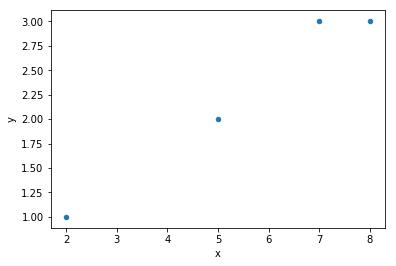

In [8]:
X = [2, 5, 7, 8]
y = [1, 2, 3, 3]

plot_ex2(X, y)

Check graphically that the model you obtained fits well with the data using the following cell (complete the first two lines).

In [9]:
#theta_0 =                          # <- TO UNCOMMENT AND TO COMPLETE (intercept)
#theta_1 =                          # <- TO UNCOMMENT AND TO COMPLETE (slope)

#plot_ex2(X, y, theta_0, theta_1)   # <- TO UNCOMMENT

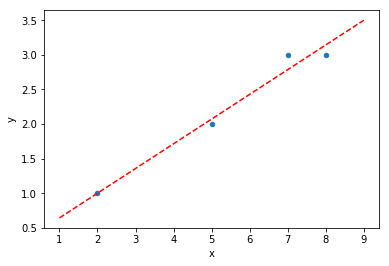

In [10]:
theta_0 = 2./7.
theta_1 = 5./14.

plot_ex2(X, y, theta_0, theta_1)

## Linear regression: an approximated solution using a *gradient descent* method

When $(X^TX)^{-1}$ cannot be easily computed (e.g. no analytical solution or $\mathcal{D}$ contains a lot of examples or the dimension of the solution space $\mathcal{X}$ is too large), an approximated solution can be computed using a *gradient descent method*.

$\nabla_{\theta}E(\hat{\theta})$ gives the direction of the largest slope at the point $\hat{\theta}$.
Thus, if we explore iteratively the parameter's space by following the opposite direction of this gradient as described in the following definition, we should converge to the parameter $\theta^*$ that minimize the MSE i.e. the parameter $\theta^*$ such that $\nabla_{\theta^*}E(\hat{\theta^*}) = 0$.

Starting from a random point $\theta$, the gradient descent method proposes a new point 
$\theta \leftarrow \theta - \eta \nabla_{\theta}E(\theta)$ at each iteration until a stopping criterion has been reached: e.g. $||\nabla_{\theta}E(\theta)||_2^2 > \epsilon_{\delta}$ with $\epsilon_{\delta}$ a chosen minimal length for the gradient to continue iterations.

The *learning rate* $\eta \in \mathbb{R}_+^*$ is a parameter to tweak for the considered problem.
- If $\eta$ is too large, the optimization may not converge toward 0.
- If $\eta$ is too small, the optimization may require a lot of iterations to converge.

### Exercise 3

Implement a gradient descent method to solve exercise 2 with an approximated solution.
Use the analytic formulation of $\nabla_{\theta}E(\theta)$ that has been computed in exercise 1.

You can use a very basic stopping criteria: the number of iterations (e.g. 10000).
You can start with $\eta = 0.001$.

Print the value of $\theta$ and $E(\theta)$ obtained at each iteration.
Check that $E(\theta)$ converges to 0 and that $\theta$ converges to the solution obtained in exercise 2.

Restart the optimization using a different *learning rate* $\eta$. What do you observe ?

## Linear regression with Scikit Learn

Let's play with the Scikit Learn implementation of linear regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html

Use the `gen_1d_linear_regression_samples()` function (defined above) to generate a dataset and `plot_1d_regression_samples()` to plot it.

In [ ]:
df = gen_1d_linear_regression_samples()

plot_1d_regression_samples(df)

Once the dataset is ready, let's make the regressor and train it with the following code:

In [ ]:
model = sklearn.linear_model.LinearRegression()

model.fit(df[['x']], df[['y']])

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

In [ ]:
plot_1d_regression_samples(df, model=model)

### Exercise 4

What are the optimal parameters $\theta_1$ (intercept) and $\theta_2$ obtained ?
(use `model.coef_` and `model.intercept_` attributes)

Write the mathematical definition of your model.

...

Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{-2 \\ 2}, x_{p2} = \pmatrix{2 \\ 6}, x_{p3} = \pmatrix{6 \\ 0}$$

## Polynomial regression

It is a common practice to use linear models trained on nonlinear functions of the data in machine learning. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data.

For instance, a linear model can be extended by making polynomial features from the coefficients. Linear model in exercises 1 and 2 looks like this (one-dimensional data):

$$f_{\theta}(x) = \theta_0 + \theta_1 x$$

If we want to fit a quadratic curve to the data instead of a line, we can combine the features in second-order polynomials, so that the model looks like this:

$$f_{\theta}(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

This is still a linear model: to illustrate this, imagine creating a new variable

$$z = [x, x^2]$$

With this re-labeling of the data, our problem can be written

$$f_{\theta}(x) = \theta_0 + \theta_1 z_1 + \theta_2 z_2$$

The resulting polynomial regression is in the same class of linear models we'd considered above (i.e. the model is linear in $\theta$) and can be solved by the same techniques. Thus the linear model has the flexibility to fit a much broader range of data.

### Exercise 5

Use the previous equations to compute **by hand** (i.e. on a sheet of paper) the optimal parameters $\theta_1$ and $\theta_2$ of the model $y = \theta_1 x + \theta_1 x^2$ to best fit the following dataset (of four examples):

$$\mathcal{D} = \left\{
\begin{pmatrix} 1 \\ 1.8 \end{pmatrix},
\begin{pmatrix} 2 \\ 2.7 \end{pmatrix},
\begin{pmatrix} 3 \\ 3.4 \end{pmatrix},
\begin{pmatrix} 4 \\ 3.8 \end{pmatrix},
\begin{pmatrix} 5 \\ 3.9 \end{pmatrix}
\right\}$$

In [ ]:
X = [1, 2, 3, 4, 5]
y = [1.8, 2.7, 3.4, 3.8, 3.9]

plot_ex4(X, y)

Check graphically that the model you obtained fits well with the data using the following cell (complete the first two lines).

In [ ]:
#theta_1 =                          # <- TO UNCOMMENT AND TO COMPLETE
#theta_2 =                          # <- TO UNCOMMENT AND TO COMPLETE

#plot_ex4(X, y, theta_1, theta_2)   # <- TO UNCOMMENT

## Polynomial regression with Scikit Learn

Let's play with the Scikit Learn implementation of polynomial regression.
The official documentation is there: https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

First we make the dataset, plot it, make the regressor and train it with the following code:

In [ ]:
df = gen_1d_polynomial_regression_samples(n_samples=20)

plot_1d_regression_samples(df)

polynomial_features = sklearn.preprocessing.PolynomialFeatures(degree=4)  # Try with degree = 1, 4 and 15
linear_regression = sklearn.linear_model.LinearRegression(fit_intercept=False)

model = sklearn.pipeline.Pipeline([("polynomial_features", polynomial_features),
                                   ("linear_regression", linear_regression)])

model.fit(df[['x']], df[['y']])

In `sklearn.preprocessing.PolynomialFeatures()`, `degree` is the degree of the polynomal function.

The following cell plots the learned model (the red dashed line) and the dataset $\mathcal{D}$ (blue points).

In [ ]:
plot_1d_regression_samples(df, model=model)

### Exercise 6

What are the optimal parameters $\theta_1, \theta_2, \dots$ obtained ?
(use the `linear_regression.coef_[0][0]` attribute for the intercept and `linear_regression.coef_[0][1:]` for the others coefficients)

Write the mathematical definition of your model.

...

Use the `model.predict()` function to guess the class of the following points:

$$x_{p1} = \pmatrix{1 \\ 2}, x_{p2} = \pmatrix{2 \\ 6}, x_{p3} = \pmatrix{6 \\ 0}$$

In `sklearn.preprocessing.PolynomialFeatures()`, change the value of `degree` and describe what happen on the plot (use e.g. 1 and 15).
What is the name of the observed phenomenons ?

...

## CO2 Emission Forecast (bonus)

In this exercise, you will forecast 5 years of future CO2 emission from power generation using natural gas.

This exercise use a dataset taken from https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima.

This public dataset contain monthly carbon dioxide emissions from electricity generation. The dataset includes CO2 emissions starting January 1973 to July 2016.

In [ ]:
df = pd.read_csv("natural_gas_co2_emissions_for_electric_power_sector.csv", parse_dates=[0]) #, index_col=0) #, squeeze=True)
df.head()

In [ ]:
df.plot(x='date', y='co2_emissions', figsize=(15,10), title='Natural Gas Electric Power Sector CO2 Emissions');

### Exercise 7

Implement a model to make predictions on this dataset.
Use polynomial basis functions plus a sinusoid to handle the seasonality of this time series: $\sin(2. \pi t / 12.)$ (this signal contains a periodic component of 12 months). 